In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp
from joypy import joyplot
import matplotlib.cm as cm
import os
import pandas as pd
plt.rcParams["svg.fonttype"] = "none"  # Ensures the text is not converted to paths
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from sklearn.inspection import PartialDependenceDisplay
import shap
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import itertools
from sklearn.metrics import confusion_matrix

In [14]:

def plot_confusion_matrix_percent(dataframe, name, threshold=0.5):
    y_true = dataframe['smoops_naive'].map({True: 1, False: 0}).values
    y_pred = (dataframe.iloc[:, -1] >= threshold).astype(int)
    
    cm = confusion_matrix(y_true, y_pred)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    plt.figure(figsize=(3, 3))
    sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix (in percentages) {name}')
    
    plt.show()

def plot_roc_curve(dataframe, name):
    y_true = dataframe['smoops_naive'].map({True: 1, False: 0}).values
    y_pred_prob = dataframe.iloc[:, -1]
    y_pred_prob = y_pred_prob.astype(float)
    auc_score = roc_auc_score(y_true, y_pred_prob)
    print(f"AUROC: {auc_score}")

    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    print(f"ROC AUC: {roc_auc}")
    
    plt.figure(figsize=(3, 3))
    plt.plot(fpr, tpr, color="#08316D", lw=2, label=f'ROC curve (AUROC = {roc_auc:.2f})')
    plt.fill_between(fpr, tpr, color="#F6FAFF", alpha=0.9)
    plt.plot([0, 1], [0, 1], color="black", lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('FPR', fontsize=14)
    plt.ylabel('TPR', fontsize=14)
    plt.title(f'Receiver Operating Characteristic (ROC) Curve {name}')
    plt.legend(loc="lower right")
    plt.show()

Processing paris_intergroup:paris_intragroup
/ceph/hpc/home/novljanj/data_storage/projects/smOOPS_paper/Analysis/Exploratory/Model_Training/Models/Final_Training_Run/training_run_12092024_163543175/paris_intergroup:paris_intragroup/evaluated_trained_model/original_file_with_predictions.tsv


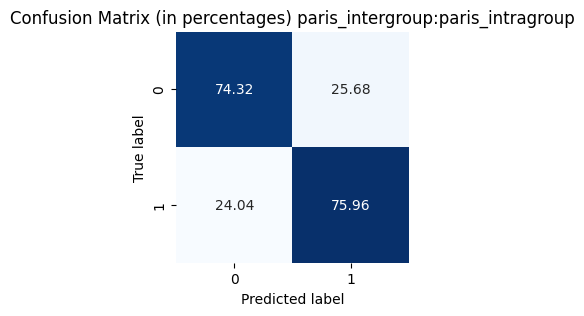

AUROC: 0.8338280903854675
ROC AUC: 0.8338280903854675


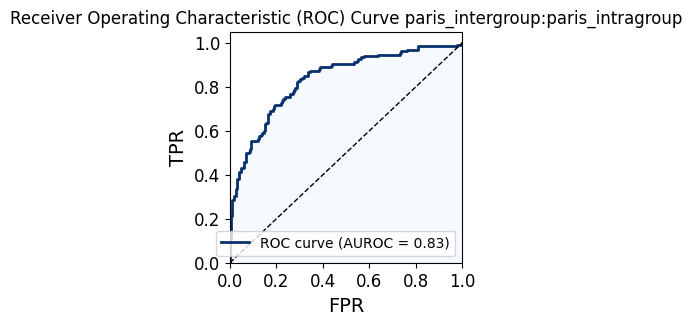

Processing sequence:
/ceph/hpc/home/novljanj/data_storage/projects/smOOPS_paper/Analysis/Exploratory/Model_Training/Models/Final_Training_Run/training_run_12092024_163543175/sequence:/evaluated_trained_model/original_file_with_predictions.tsv


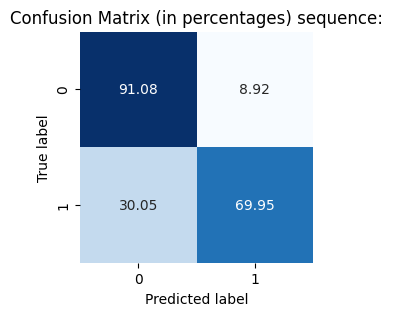

AUROC: 0.9121252399940926
ROC AUC: 0.9121252399940926


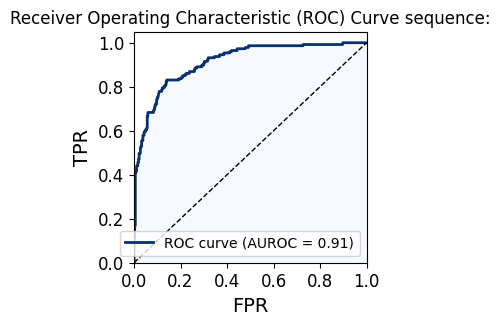

Processing rnafold
/ceph/hpc/home/novljanj/data_storage/projects/smOOPS_paper/Analysis/Exploratory/Model_Training/Models/Final_Training_Run/training_run_12092024_090155232/rnafold/evaluated_trained_model/original_file_with_predictions.tsv


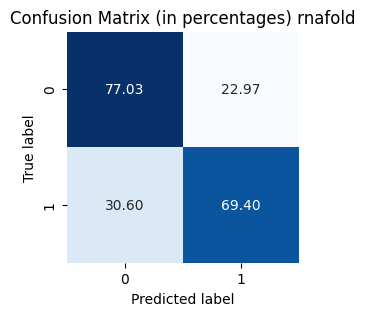

AUROC: 0.8206911829862649
ROC AUC: 0.8206911829862649


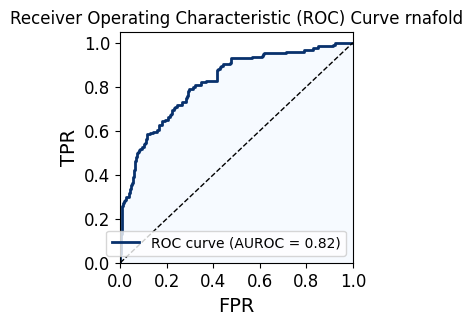

Processing postar3
/ceph/hpc/home/novljanj/data_storage/projects/smOOPS_paper/Analysis/Exploratory/Model_Training/Models/Final_Training_Run/training_run_19092024_085523219/postar3/evaluated_trained_model/original_file_with_predictions.tsv


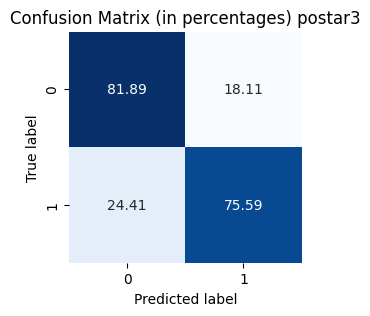

AUROC: 0.8794855367488512
ROC AUC: 0.8794855367488512


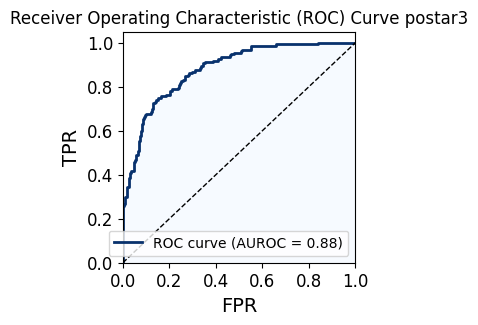

Processing paris_intramol
/ceph/hpc/home/novljanj/data_storage/projects/smOOPS_paper/Analysis/Exploratory/Model_Training/Models/Final_Training_Run/training_run_12092024_090155232/paris_intramol/evaluated_trained_model/original_file_with_predictions.tsv


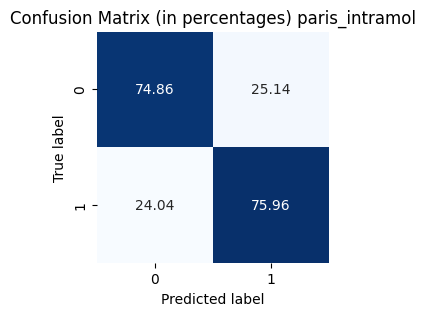

AUROC: 0.8508492098656033
ROC AUC: 0.8508492098656033


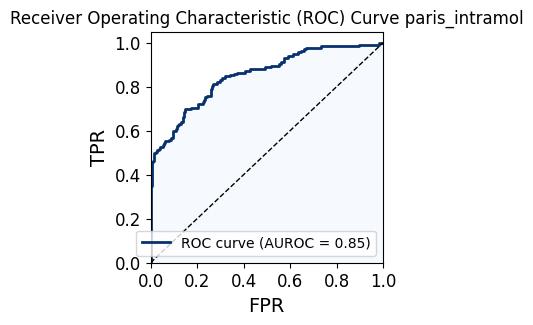

Processing m6a
/ceph/hpc/home/novljanj/data_storage/projects/smOOPS_paper/Analysis/Exploratory/Model_Training/Models/Final_Training_Run/training_run_12092024_163543175/m6a/evaluated_trained_model/original_file_with_predictions.tsv


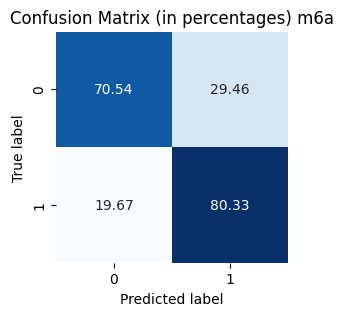

AUROC: 0.8357185053906364
ROC AUC: 0.8357185053906364


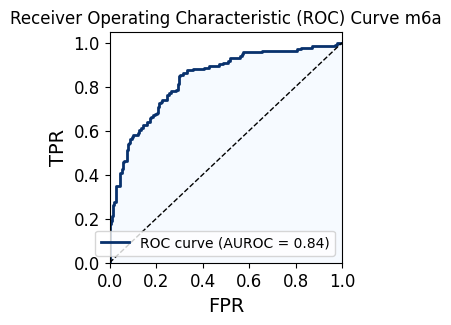

Processing global_iclip
/ceph/hpc/home/novljanj/data_storage/projects/smOOPS_paper/Analysis/Exploratory/Model_Training/Models/Final_Training_Run/training_run_19092024_085510036/global_iclip/evaluated_trained_model/original_file_with_predictions.tsv


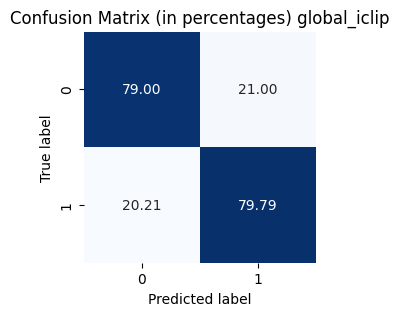

AUROC: 0.8858991051315437
ROC AUC: 0.8858991051315437


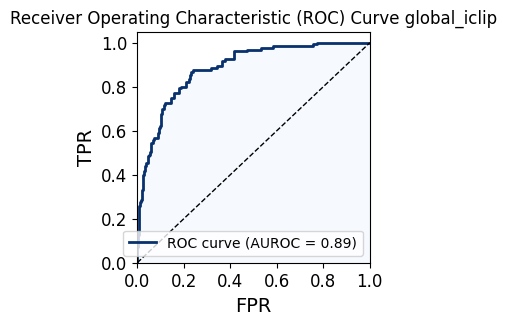

In [15]:
runs = ['training_run_12092024_163543175', 
        'training_run_12092024_163543175', 
        'training_run_12092024_090155232', 
        'training_run_19092024_085523219', 
        'training_run_12092024_090155232', 
        'training_run_12092024_163543175', 
        'training_run_19092024_085510036',
        ]

datasets = ['paris_intergroup:paris_intragroup', 
            'sequence:', 
            'rnafold', 
            'postar3', 
            'paris_intramol', 
            'm6a', 
            'global_iclip', 
            ]

files = {}
for index in range(len(runs)):
    # Replace this with the path to your main directory
    main_dir = 'Model_Training/Models/Final_Training_Run'

    test_set = set(pd.read_csv(f"Model_Training/Models/Final_Training_Run/{runs[index]}/created_datasets/testing.tsv", sep='\t')["transcript_id"])
    val_set = set(pd.read_csv(f"Model_Training/Models/Final_Training_Run/{runs[index]}/created_datasets/validation.tsv", sep='\t')["transcript_id"])
    test_and_val_set = test_set.union(val_set)

    if datasets[index] in files:
        continue
    print(f"Processing {datasets[index]}")
    main_dir = f"Model_Training/Models/Final_Training_Run/{runs[index]}"
    file_path = os.path.join(main_dir, datasets[index], "evaluated_trained_model/original_file_with_predictions.tsv")
    print(file_path)
    original_file = pd.read_csv(file_path, sep="\t")
    original_file = original_file[original_file["transcript_id"].isin(test_and_val_set)]

    #original_file = original_file[["transcript_id", "smoops_naive", f"smOOPS_pred_{datasets[index]}"]]
    original_file.drop_duplicates(inplace=True)


    plot_confusion_matrix_percent(original_file, datasets[index])
    plot_roc_curve(original_file, datasets[index])
    files[datasets[index]] = original_file
